## YZV 202E Project
Ayah A M Hussein - 150220917 <br>
Sude Dilay Tunc - 150230716 <br>
 Ramazan Hoşgör - 150210301

## Introduction

This notebook presents a comprehensive approach for identifying optimal locations for solar energy systems across Turkey. By leveraging environmental data, the objective is to maximize solar energy output while minimizing inefficiencies due to spatial clustering.

The workflow includes:
- Importing and processing NASA datasets.
- Defining a solar suitability score based on weighted environmental factors including irradiance, clearness index, cloud cover, and precipitation.
- Applying optimization techniques : Genetic Algorithm, Particle swarm and simulated annealing to select the most suitable locations for solar panel installation.
- Visualizing results to support decision making and ensure geographic diversity.
- Comparision between the used algorithms

This project can be used by researchers, engineers, and policymakers aiming to plan sustainable, efficient, and strategically distributed solar energy systems.


## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.distance import geodesic
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Layout
from IPython.display import display, clear_output
from scipy.spatial.distance import pdist
import folium
import random
import time

## Solar suitability score Function


In [2]:
def calculate_suitability(row, w0=0.8, w1=0.3, w2=-0.2, w3=-0.2):
    return w0 * row['ALLSKY_SFC_SW_DWN'] + w1 * row['ALLSKY_KT'] + w2 * row['CLOUD_AMT'] + w3 * row['PRECTOTCORR']


## Load the dataset

In [3]:
#load the dataset that includes the coordinates of 733 locations in turkey with their suitability score.
file_path = r"lat_lon_score.csv"
df_input = pd.read_csv(file_path)

# Load the installed solar power plant coordinates to use in penalty term
solar_df = pd.read_csv("turkey_solar_filtered.csv")

# Create a list of (lat, lon) tuples 
solar_sites = list(zip(solar_df["latitude"], solar_df["longitude"]))


# Solar Suitability Heatmap Across Türkiye

C:\Users\aya20\AppData\Local\Temp\ipykernel_14132\2737507845.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))  #if this doesnt work uncomment the code above


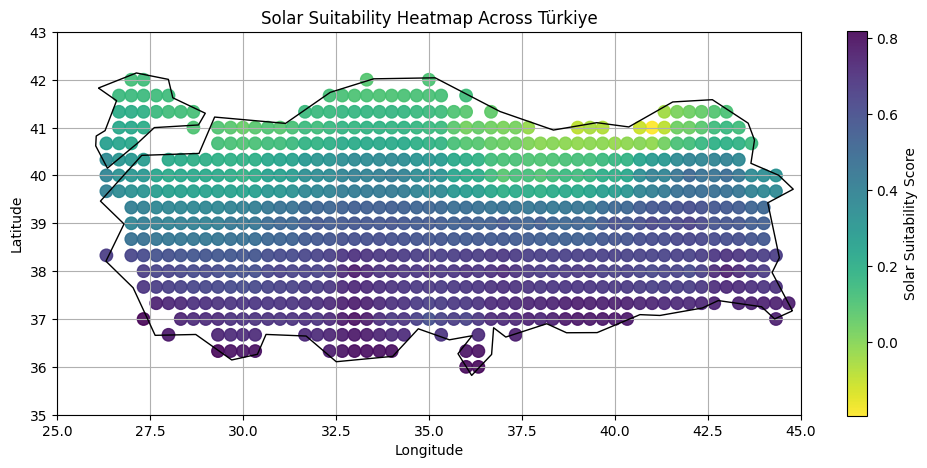

In [4]:
# Load Türkiye shape from GeoPandas built-in dataset
"""
file_path = "./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(file_path)
turkey = world[world['ADMIN'] == 'Turkey']
"""
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))  #if this doesnt work uncomment the code above
turkey = world[world.name == "Turkey"]

# Plot Türkiye outline and overlay the heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Türkiye outline
turkey.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot the heatmap points
scatter = ax.scatter(
    df_input['lon'], df_input['lat'],
    c=df_input['avg_score'], cmap="viridis_r", s=80, alpha=0.9
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Solar Suitability Score', shrink=0.5)

# Set titles and labels
ax.set_title('Solar Suitability Heatmap Across Türkiye')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set Türkiye bounding box
ax.set_xlim([25, 45])
ax.set_ylim([35, 43])

plt.grid(True)
plt.show()


## Genetic Algorithm

In [7]:
def genetic_algorithm(df, population_size, generations, mutation_rate, num_points=20, verbose=False, output_file='best_20_points_ga.csv'):
    """
    Genetic Algorithm for optimizing the selection of solar panel installation sites.

    Args:
        df (DataFrame): Input DataFrame containing site data with 'avg_score', 'lat', and 'lon'.
        population_size (int): Number of individuals in the population.
        generations (int): Number of generations "iterations" to run the algorithm.
        mutation_rate (float): Probability of mutation per individual.
        num_points (int): Number of sites to select in each individual.
        verbose (bool): If True, print progress every 10 generations.
        output_file (str): Path to save the best points CSV file.

    Returns:
        best_individual (array): Indices of the best selected points.
        best_fitness (float): Fitness score of the best individual.
        fitness_scores (list): List of best fitness scores per generation.
        runtime (float): Time taken to complete the algorithm.
    """
    df = df.copy()
    start_time = time.time()  # Start timing

    # Define the fitness function to evaluate solution quality
    def fitness_function(point_indices):
        points = df.loc[point_indices]
        suitability_score = points['avg_score'].sum()

        # Grid proximity penalty among selected points 
        intra_penalty = 0
        lat_array = points['lat'].values
        lon_array = points['lon'].values

        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                lat_diff_km = abs(lat_array[i] - lat_array[j]) * 111
                lon_diff_km = abs(lon_array[i] - lon_array[j]) * 86.25
                distance_km = np.sqrt(lat_diff_km**2 + lon_diff_km**2)
                if distance_km < 100:
                    intra_penalty += 1 / (distance_km + 1e-6)

        # Proximity penalty to existing solar plants in Turkey 
        proximity_penalty = 0
        if solar_sites is not None:
            for row in points.itertuples():
                for solar_lat, solar_lon in solar_sites:
                    lat_diff_km = abs(row.lat - solar_lat) * 111
                    lon_diff_km = abs(row.lon - solar_lon) * 86.25
                    dist = np.sqrt(lat_diff_km**2 + lon_diff_km**2)
                    if dist < 100:
                        proximity_penalty += 1 / (dist + 1e-6)

        # Combine both penalties using weighted coefficients
        lambda_intra = 10
        lambda_prox = 10
        total_penalty = lambda_intra * intra_penalty + lambda_prox * proximity_penalty

        return suitability_score - total_penalty

    # Initialize population with random selections
    def create_initial_population():
        return [np.random.choice(df.index, num_points, replace=False) for _ in range(population_size)]

    # Select the top-performing half of the population
    def selection(population, fitnesses):
        indices = np.argsort(fitnesses)
        return [population[i] for i in indices[-(population_size // 2):]]

    # Combine two parents to produce two children
    def crossover(parent1, parent2):
        split = len(parent1) // 2
        child1 = list(dict.fromkeys(np.concatenate((parent1[:split], parent2[split:]))))
        child2 = list(dict.fromkeys(np.concatenate((parent2[:split], parent1[split:]))))

        while len(child1) < len(parent1):
            new_point = random.choice([i for i in df.index if i not in child1])
            child1.append(new_point)

        while len(child2) < len(parent2):
            new_point = random.choice([i for i in df.index if i not in child2])
            child2.append(new_point)

        return np.array(child1[:len(parent1)]), np.array(child2[:len(parent1)])

    # Replace one gene in the individual randomly according to mutation_rate
    def mutate(individual, mutation_rate):
        if random.random() < mutation_rate:
            idx = random.randint(0, len(individual) - 1)
            new_point = random.choice([i for i in df.index if i not in individual])
            individual[idx] = new_point

    # Initialize algorithm variables
    fitness_scores = []
    population = create_initial_population()
    best_individual = None
    best_fitness = -float('inf')

    # Main genetic algorithm loop
    for generation in range(generations):
        fitnesses = [fitness_function(ind) for ind in population]

        if max(fitnesses) > best_fitness:
            best_fitness = max(fitnesses)
            best_individual = population[np.argmax(fitnesses)]

        selected = selection(population, fitnesses)
        next_generation = [best_individual.copy()]  # preserve elite

        while len(next_generation) < population_size:
            parents = random.sample(selected, 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])
            mutate(offspring1, mutation_rate)
            mutate(offspring2, mutation_rate)
            next_generation.extend([offspring1, offspring2])

        population = next_generation[:population_size]

        if verbose and generation % 10 == 0:
            print(f"Generation {generation + 1}, Best Fitness: {best_fitness:.4f}")

        fitness_scores.append(best_fitness)

    # Save the best solution to CSV
    best_points = df.loc[best_individual]
    best_points.to_csv(output_file, index=False)
    print(f"Best 20 points saved to '{output_file}'")

    end_time = time.time()  # End timing
    runtime = end_time - start_time
    print(f"⏱️ Runtime: {runtime:.2f} seconds")

    return best_individual, best_fitness, fitness_scores, runtime


## Genetic Algorithm with early stopping machanism

In [8]:
def genetic_algorithm_earlyStop(df, population_size, generations, mutation_rate, num_points=20, verbose=False, output_file='best_20_points_ga_earlyStop.csv'):
    """
    This Algorithm implementation is exactly the same as genetic_algorithm but with early stopping

    Args:
        df (DataFrame): Input DataFrame with 'avg_score', 'lat', 'lon'.
        population_size (int): Number of individuals in the population.
        generations (int): Max number of generations to run.
        mutation_rate (float): Probability of mutation.
        num_points (int): Number of locations to select per solution.
        verbose (bool): If True, prints updates every 10 generations.
        output_file (str): Path to save the best points CSV file.

    Returns:
        best_individual (array): Best solution (indices of selected sites).
        best_fitness (float): Fitness score of the best solution.
        fitness_scores (list): Best fitness score per generation.
        runtime (float): Total algorithm runtime in seconds.
    """
    df = df.copy()
    start_time = time.time()  # Start timing

    def fitness_function(point_indices):
        points = df.loc[point_indices]
        suitability_score = points['avg_score'].sum()

        # Grid proximity penalty among selected points 
        intra_penalty = 0
        lat_array = points['lat'].values
        lon_array = points['lon'].values

        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                lat_diff_km = abs(lat_array[i] - lat_array[j]) * 111
                lon_diff_km = abs(lon_array[i] - lon_array[j]) * 86.25
                distance_km = np.sqrt(lat_diff_km**2 + lon_diff_km**2)
                if distance_km < 100:
                    intra_penalty += 1 / (distance_km + 1e-6)

        # Proximity penalty to real solar plants
        proximity_penalty = 0
        if solar_sites is not None:
            for row in points.itertuples():
                for solar_lat, solar_lon in solar_sites:
                    lat_diff_km = abs(row.lat - solar_lat) * 111
                    lon_diff_km = abs(row.lon - solar_lon) * 86.25
                    dist = np.sqrt(lat_diff_km**2 + lon_diff_km**2)
                    if dist < 100:
                        proximity_penalty += 1 / (dist + 1e-6)

        lambda_intra = 10
        lambda_prox = 10
        total_penalty = lambda_intra * intra_penalty + lambda_prox * proximity_penalty

        return suitability_score - total_penalty

    def create_initial_population():
        return [np.random.choice(df.index, num_points, replace=False) for _ in range(population_size)]

    def selection(population, fitnesses):
        indices = np.argsort(fitnesses)
        return [population[i] for i in indices[-(population_size // 2):]]

    def crossover(parent1, parent2):
        split = len(parent1) // 2
        child1 = list(dict.fromkeys(np.concatenate((parent1[:split], parent2[split:]))))
        child2 = list(dict.fromkeys(np.concatenate((parent2[:split], parent1[split:]))))

        while len(child1) < len(parent1):
            new_point = random.choice([i for i in df.index if i not in child1])
            child1.append(new_point)

        while len(child2) < len(parent2):
            new_point = random.choice([i for i in df.index if i not in child2])
            child2.append(new_point)

        return np.array(child1[:len(parent1)]), np.array(child2[:len(parent1)])

    def mutate(individual, mutation_rate):
        if random.random() < mutation_rate:
            idx = random.randint(0, len(individual) - 1)
            new_point = random.choice([i for i in df.index if i not in individual])
            individual[idx] = new_point

    fitness_scores = []
    population = create_initial_population()
    best_individual = None
    best_fitness = -float('inf')
    no_improvement_count = 0
    tolerance = 0.01  # Minimum required improvement
    patience = 50  # Stop if no improvement for 50 generations
    min_generations = 100  # Run at least this many generations before early stopping

    for generation in range(generations):
        fitnesses = [fitness_function(ind) for ind in population]
        current_best_fitness = max(fitnesses)

        if current_best_fitness > best_fitness + tolerance:
            best_fitness = current_best_fitness
            best_individual = population[np.argmax(fitnesses)]
            no_improvement_count = 0
        else:
            if generation >= min_generations:
                no_improvement_count += 1

        fitness_scores.append(best_fitness)

        if generation >= min_generations and no_improvement_count >= patience:
            if verbose:
                print(f"⛔ Early stopping at generation {generation + 1} due to no significant improvement.")
            break

        selected = selection(population, fitnesses)
        next_generation = []

        while len(next_generation) < population_size:
            parents = random.sample(selected, 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])
            mutate(offspring1, mutation_rate)
            mutate(offspring2, mutation_rate)
            next_generation.extend([offspring1, offspring2])

        population = next_generation[:population_size]

        if verbose and generation % 10 == 0:
            print(f"Generation {generation + 1}, Best Fitness: {best_fitness:.4f}")

    # Save best solution to CSV
    best_points = df.loc[best_individual]
    best_points.to_csv(output_file, index=False)
    print(f"✅ Best 20 points saved to '{output_file}'")

    end_time = time.time()
    runtime = end_time - start_time
    print(f"⏱️ Runtime: {runtime:.2f} seconds")

    return best_individual, best_fitness, fitness_scores, runtime


## Run Genetic Algorithm

In [9]:
# Run the algorithm with fixed parameters
if __name__ == "__main__":
 
    best_assignment_ga_optimal, best_fitness_ga_optimal, fitness_scores_ga_optimal,runtime_ga_optimal = genetic_algorithm(
        df=df_input,
        population_size=75,
        generations=300,
        mutation_rate=0.2,
        num_points=20,
        verbose=True,
        output_file='best_20_points_ga_optimal.csv'
    )

Generation 1, Best Fitness: 3.7418
Generation 11, Best Fitness: 7.0659
Generation 21, Best Fitness: 8.3782
Generation 31, Best Fitness: 9.7674
Generation 41, Best Fitness: 9.8571
Generation 51, Best Fitness: 10.6659
Generation 61, Best Fitness: 11.0378
Generation 71, Best Fitness: 11.3492
Generation 81, Best Fitness: 11.7680
Generation 91, Best Fitness: 11.8041
Generation 101, Best Fitness: 11.9984
Generation 111, Best Fitness: 12.3205
Generation 121, Best Fitness: 12.3205
Generation 131, Best Fitness: 12.3494
Generation 141, Best Fitness: 12.3494
Generation 151, Best Fitness: 12.4335
Generation 161, Best Fitness: 12.4335
Generation 171, Best Fitness: 12.4624
Generation 181, Best Fitness: 12.4624
Generation 191, Best Fitness: 12.4810
Generation 201, Best Fitness: 12.4810
Generation 211, Best Fitness: 12.4900
Generation 221, Best Fitness: 12.4900
Generation 231, Best Fitness: 12.5077
Generation 241, Best Fitness: 12.6180
Generation 251, Best Fitness: 12.6180
Generation 261, Best Fitness

## Greedy top-20 strategy


In [4]:

# Select the top 20 points with the highest avg_score
top_20_points = df_input.nlargest(20, 'avg_score')

# Save to CSV
output_path_top20 = "best_20_points_greedy.csv"
top_20_points.to_csv(output_path_top20, index=False)

best_fitness_greedy = top_20_points["avg_score"].sum()
print("Greedy Fitness Score :", best_fitness_greedy)


Greedy Fitness Score : 15.70134


## Experiments with GA


In [ ]:
# initializing the experiment variables
pop_size = [25,50,75]
mut_rate = [0.05,0.1,0.2,0.3]

### Population Size Experiments 


In [18]:
population_results = []  # initialize an empty list to store results

for pop in pop_size:
    best_assignment_ga, best_fitness_ga, fitness_scores_ga, runtime_ga = genetic_algorithm(
        df=df_input.copy(),      
        population_size=pop,
        generations=300,
        mutation_rate=0.2,
        num_points=20,
        verbose=False
    )
    print(f"Population Size: {pop}, Best Fitness: {best_fitness_ga}")

    # Collect results into the pop_results list
    population_results.append([
        best_assignment_ga,       # (list of indices of best points)
        best_fitness_ga,          # (best fitness score)
        fitness_scores_ga,        # (list of fitness scores per generation)
        runtime_ga                # (total runtime in seconds)
    ])
# Note : this cell takes about 8mins to run


Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 41.20 seconds
Population Size: 25, Best Fitness: 12.198453657460126
Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 74.73 seconds
Population Size: 50, Best Fitness: 12.588252088456628
Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 112.01 seconds
Population Size: 75, Best Fitness: 12.841628513410203
Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 147.44 seconds
Population Size: 100, Best Fitness: 12.613166157554875


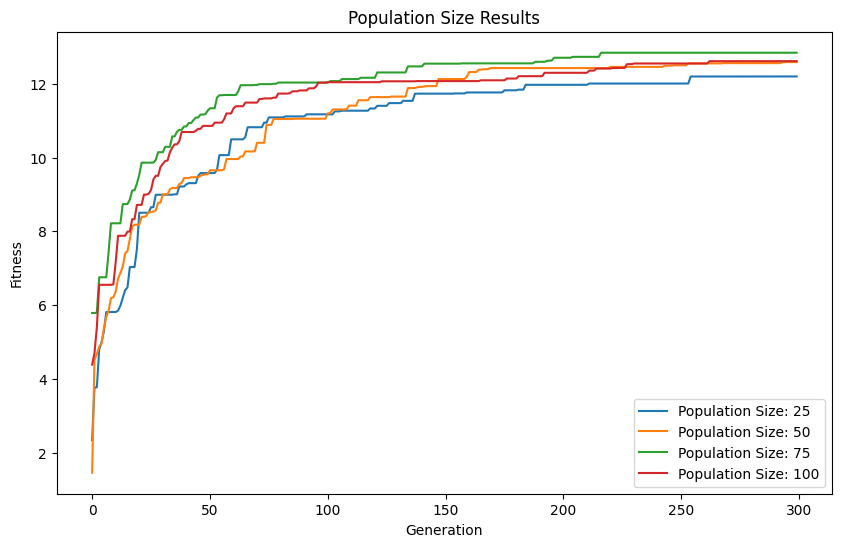

In [26]:
plt.figure(figsize=(10, 6))
for i, result in enumerate(population_results):
    plt.plot(result[2], label=f"Population Size: {pop_size[i]}")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.title("Population Size Results")
plt.show()

## Population size and time trade off

In [27]:

def summarize_ga_results(pop_size, pop_results):
    # Get the last fitness score from each fitness_scores_ga list (2 decimals)
    best_fitness_scores = [round(result[2][-1], 2) for result in pop_results]  # r[2] is fitness_scores_ga
    
    # Get the runtime, rounded to nearest integer (no decimals)
    runtimes = [int(round(result[3])) for result in pop_results]  # r[3] is runtime_ga
    
    # Build the DataFrame
    df = pd.DataFrame({
        "Population Size": pop_size,
        "Best Fitness Score": best_fitness_scores,
        "Runtime (seconds)": runtimes
    })
    
    display(df)

    # Plot results
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Population Size')
    ax1.set_ylabel('Best Fitness Score', color=color)
    ax1.plot(df['Population Size'], df['Best Fitness Score'], marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Runtime (seconds)', color=color)
    ax2.plot(df['Population Size'], df['Runtime (seconds)'], marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("GA Performance vs Population Size")
    plt.show()

    return df




,Population Size,Best Fitness Score,Runtime (seconds)
0,25,12.27,43
1,50,12.44,115
2,75,12.86,141
3,100,12.72,191


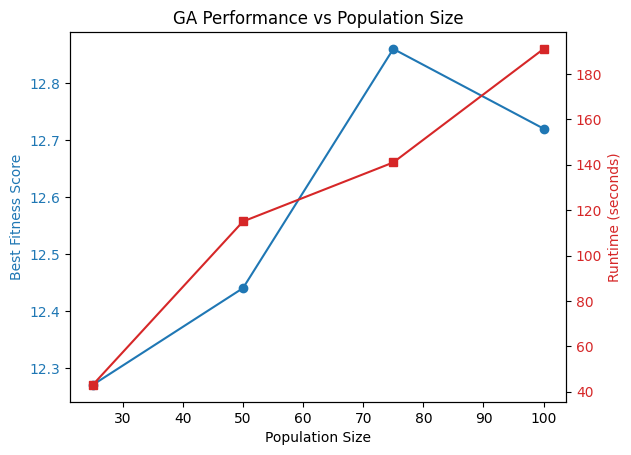

In [13]:
df_results = summarize_ga_results(pop_size, population_results)

## Mutation Rate Experiments

In [14]:
mut_results = []
for mut in mut_rate:
    best_assignment_ga, best_fitness_ga, fitness_scores_ga,runtime_ga = genetic_algorithm(
        df=df_input.copy(),      
        population_size=50,
        generations=300,
        mutation_rate=mut,
        num_points=20,
        verbose=False
    )
    print(f"Mutation Rate: {mut}, Best Fitness: {best_fitness_ga}")
    mut_results.append([best_assignment_ga, best_fitness_ga, fitness_scores_ga,runtime_ga])
# Note : this cell takes about 7mins to run

Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 92.80 seconds
Mutation Rate: 0.05, Best Fitness: 12.143688703568104
Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 90.78 seconds
Mutation Rate: 0.1, Best Fitness: 12.277970828582829
Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 79.22 seconds
Mutation Rate: 0.2, Best Fitness: 12.44498303883255
Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 119.14 seconds
Mutation Rate: 0.3, Best Fitness: 12.906260167140314


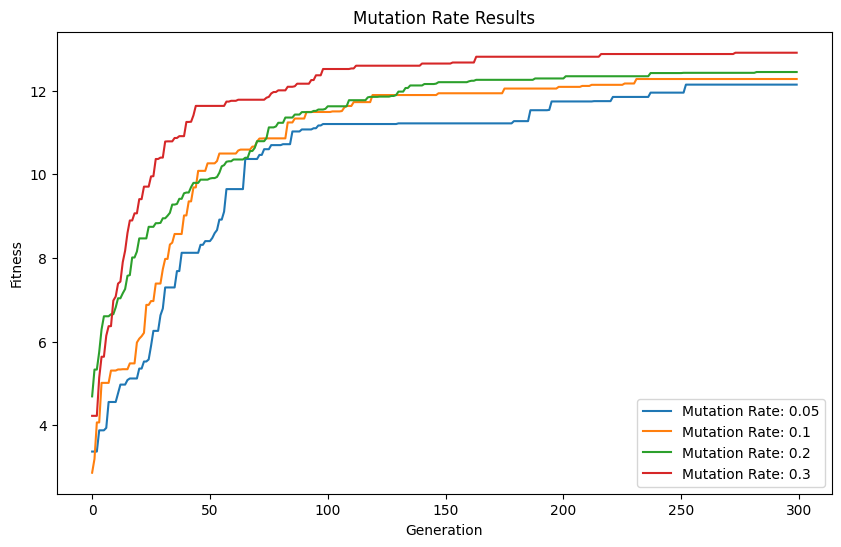

In [15]:
plt.figure(figsize=(10, 6))
for mut, result in zip(mut_rate, mut_results):
    plt.plot(result[2], label=f"Mutation Rate: {mut}")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Mutation Rate Results")
plt.legend()
plt.show()

## Generations Number Experiments

In [16]:
# Run the genetic algorithm
best_assignment_ga, best_fitness_ga, fitness_scores_ga,runtime_ga = genetic_algorithm(
    df=df_input.copy(),
    population_size=50,
    generations=2000,
    mutation_rate=0.2,
    num_points=20,
    verbose=False
)
# Note : this cell takes about 7mins to run

Best 20 points saved to 'best_20_points_ga.csv'
⏱️ Runtime: 660.52 seconds


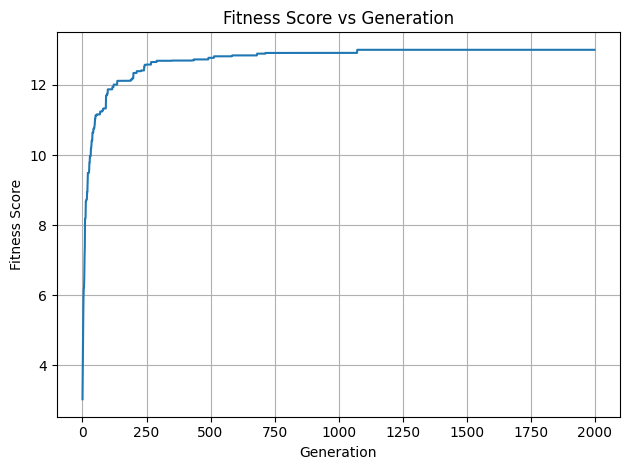

In [17]:
# Plot the fitness scores
plt.plot(fitness_scores_ga)
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Fitness Score vs Generation")
plt.grid(True)
plt.tight_layout()
plt.show()

## Generation Number Experiment with Early Stopping GA

In [ ]:
# Run the genetic algorithm with early stopping
best_assignment_ga_earlystop, best_fitness_ga_earlystop, fitness_scores_ga_earlystop,runtime_ga_earlystop = genetic_algorithm_earlyStop(
    df=df_input.copy(),
    population_size=50,
    generations=2000,
    mutation_rate=0.2,
    num_points=20,
    verbose=True
)

Generation 1, Best Fitness: 5.5974
Generation 11, Best Fitness: 7.9852
Generation 21, Best Fitness: 9.1586
Generation 31, Best Fitness: 9.5572
Generation 41, Best Fitness: 10.0014
Generation 51, Best Fitness: 10.0014
Generation 61, Best Fitness: 10.0504
Generation 71, Best Fitness: 10.2260
Generation 81, Best Fitness: 10.2819
Generation 91, Best Fitness: 10.5668
Generation 101, Best Fitness: 11.0275
Generation 111, Best Fitness: 11.1091
Generation 121, Best Fitness: 11.2658
Generation 131, Best Fitness: 11.6429
Generation 141, Best Fitness: 11.6429
Generation 151, Best Fitness: 11.7843
Generation 161, Best Fitness: 11.9569
Generation 171, Best Fitness: 11.9569
Generation 181, Best Fitness: 11.9948
Generation 191, Best Fitness: 12.3078
Generation 201, Best Fitness: 12.3078
Generation 211, Best Fitness: 12.3078
Generation 221, Best Fitness: 12.3078
Generation 231, Best Fitness: 12.3078
Generation 241, Best Fitness: 12.3920
Generation 251, Best Fitness: 12.4316
Generation 261, Best Fitnes

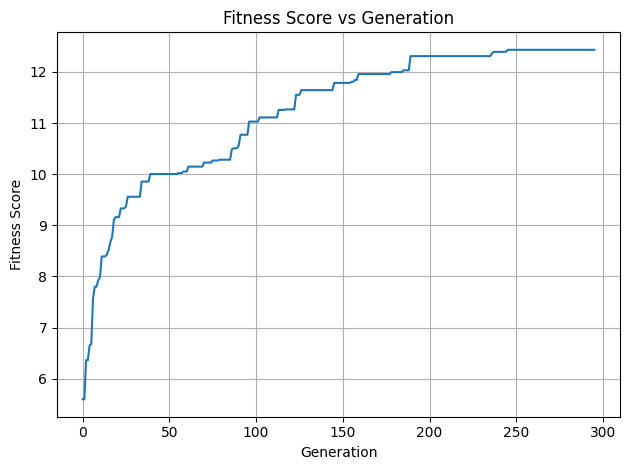

In [ ]:
# Plot the fitness scores after applying early stopping
plt.plot(fitness_scores_ga_earlystop)
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Fitness Score vs Generation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Interactive GA

In [30]:
# --- Load your data ---
df_input = pd.read_csv("lat_lon_score.csv")

# --- Layouts ---
slider_layout = Layout(width='600px', height='50px')
button_layout = Layout(width='300px', height='50px')

# --- Sliders ---
population_slider = widgets.IntSlider(
    value=50, min=25, max=100, step=10,
    description='👥 Population:', style={'description_width': '150px'},
    layout=slider_layout
)
mutation_slider = widgets.FloatSlider(
    value=0.2, min=0.01, max=1, step=0.01,
    description='🧬 Mutation Rate:', style={'description_width': '150px'},
    layout=slider_layout
)
generation_slider = widgets.IntSlider(
    value=300, min=50, max=2000, step=50,
    description='🔁 Generations:', style={'description_width': '150px'},
    layout=slider_layout
)

# --- Buttons ---
run_button = widgets.Button(
    description="🚀 Run Optimization",
    button_style='success',
    layout=button_layout
)
reset_button = widgets.Button(
    description="🔄 Reset",
    button_style='warning',
    layout=button_layout
)

# --- Output box ---
output = widgets.Output()

# --- Run callback ---
def on_button_click(b):
    with output:
        clear_output(wait=True)
        best_assignment, best_fitness, fitness_scores,runtime_ga = genetic_algorithm(
            df=df_input.copy(),
            population_size=population_slider.value,
            generations=generation_slider.value,
            mutation_rate=mutation_slider.value,
            num_points=20,
            verbose=True
        )
        # Fitness Plot
        fig1, ax1 = plt.subplots(figsize=(8, 4), constrained_layout=True)
        ax1.plot(fitness_scores, marker='o', color='mediumseagreen')
        ax1.set_title("📈 Fitness Score per Generation")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Best Fitness")
        ax1.grid(True)
        plt.show()
        # Map Plot
        """
        file_path = "./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
        world = gpd.read_file(file_path)
        turkey = world[world['ADMIN'] == 'Turkey']
        """
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) #if this doesnt work uncomment the code above
        turkey = world[world.name == "Turkey"]
        selected_points = pd.read_csv('best_20_points_ga.csv')
        gdf_points = gpd.GeoDataFrame(
            selected_points,
            geometry=gpd.points_from_xy(selected_points.lon, selected_points.lat),
            crs="EPSG:4326"
        )
        fig2, ax2 = plt.subplots(figsize=(8, 10), constrained_layout=True)
        turkey.plot(ax=ax2, color='whitesmoke', edgecolor='black')
        gdf_points.plot(ax=ax2, color='crimson', markersize=50, edgecolor='white')
        ax2.set_title("📍 Selected Solar Installation Points on Türkiye Map", fontsize=14)
        ax2.set_xlabel("Longitude")
        ax2.set_ylabel("Latitude")
        ax2.grid(True)
        plt.show()

# --- Reset callback ---
def on_reset_click(b):
    population_slider.value = 50
    mutation_slider.value = 0.2
    generation_slider.value = 300
    output.clear_output()

# --- Remove duplicate bindings and bind cleanly ---
def clear_and_bind(widget, callback):
    try:
        widget._click_handlers.callbacks.clear()
    except Exception:
        pass
    widget.on_click(callback)

clear_and_bind(run_button, on_button_click)
clear_and_bind(reset_button, on_reset_click)


# --- Layout container ---
button_row = HBox([run_button, reset_button], layout=Layout(justify_content='center', gap='20px'))
control_box = VBox(
    [population_slider, mutation_slider, generation_slider, button_row],
    layout=Layout(
        border='2px solid lightgray',
        border_radius='10px',
        box_shadow='2px 2px 5px rgba(0,0,0,0.1)',
        padding='20px',
        width='700px',
        align_items='center',
        background_color='white'
    )
)

# --- Output box with wider layout ---
output.layout = Layout(width='900px', align_items='center')

if not hasattr(run_button, "_already_displayed"):
    display(VBox([control_box, widgets.HBox([output], layout=Layout(justify_content='center', width='100%'))], 
                 layout=Layout(align_items='center', width='100%')))
    run_button._already_displayed = True

# Particle Swarm 


In [11]:
class Particle:
    def __init__(self, df, num_points):
        """
        Initialize a Particle with a random position (selection of points).

        Args:
            df (DataFrame): Data with columns 'avg_score', 'lat', 'lon'.
            num_points (int): Number of points to select in each particle.
        """
        self.df = df
        self.num_points = num_points
        self.position = np.random.choice(df.index, num_points, replace=False)  # Randomly select point indices
        self.best_position = self.position.copy()  # Initialize best_position as current
        self.best_score = self.fitness(self.position)  # Evaluate initial fitness

    def fitness(self, indices):
        """
        Compute fitness of a particle's position, including penalties.

        Args:
            indices (array): Indices of selected points in the DataFrame.

        Returns:
            float: Fitness score = suitability score - penalties.
        """
        points = self.df.loc[indices]
        suitability_score = points['avg_score'].sum()  # Sum of avg_scores

        # --- Intra-point penalty for clustering too close together ---
        intra_penalty = 0
        lat_array = points['lat'].values
        lon_array = points['lon'].values

        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                lat_diff_km = abs(lat_array[i] - lat_array[j]) * 111  # Approx km for lat diff
                lon_diff_km = abs(lon_array[i] - lon_array[j]) * 86.25  # Approx km for lon diff
                dist = np.sqrt(lat_diff_km**2 + lon_diff_km**2)
                if dist < 100:
                    intra_penalty += 1 / (dist + 1e-6)  # Avoid div by 0, encourage spread

        # --- Proximity penalty to real solar sites ---
        proximity_penalty = 0
        if solar_sites is not None:
            for row in points.itertuples():
                for solar_lat, solar_lon in solar_sites:
                    lat_diff_km = abs(row.lat - solar_lat) * 111
                    lon_diff_km = abs(row.lon - solar_lon) * 86.25
                    dist = np.sqrt(lat_diff_km**2 + lon_diff_km**2)
                    if dist < 100:
                        proximity_penalty += 1 / (dist + 1e-6)

        # Apply weighted penalties
        lambda_intra = 10  # Weight for intra-point proximity
        lambda_prox = 10   # Weight for proximity to existing solar sites
        penalty = lambda_intra * intra_penalty + lambda_prox * proximity_penalty

        return suitability_score - penalty  # Final fitness

    def update(self, global_best, c1=0.4, c2=0.4):
        """
        Update particle's position based on PSO rules.

        Args:
            global_best (array): The best-known position across all particles.
            c1 (float): Cognitive coefficient (tendency to follow personal best).
            c2 (float): Social coefficient (tendency to follow global best).
        """
        new_position = list(self.position)  # Start from current position

        for i in range(len(new_position)):
            r = random.random()  # Random number for probabilistic update
            if r < c2:
                new_position[i] = global_best[i]  # Social component: follow global best
            elif r < c2 + c1:
                new_position[i] = self.best_position[i]  # Cognitive component: follow personal best
            # Else: inertia, keep current gene

        # Remove duplicates while preserving order
        new_position = list(dict.fromkeys(new_position))

        # Add random unique points until reaching num_points
        while len(new_position) < self.num_points:
            candidate = random.choice(self.df.index)
            if candidate not in new_position:
                new_position.append(candidate)

        # Update position
        self.position = np.array(new_position)

        # Evaluate new fitness
        score = self.fitness(self.position)

        # Update personal best if improved
        if score > self.best_score:
            self.best_score = score
            self.best_position = self.position.copy()


In [12]:
def particle_swarm_optimization(df, swarm_size=50, iterations=100, num_points=20,
                                 c1_start=0.6, c1_end=0.5, c2_start=0.3, c2_end=0.2,
                                 verbose=True, output_file='best_20_points_pso.csv'):
    """
    Particle Swarm Optimization (PSO) for solar site selection.

    Args:
        df (DataFrame): Input DataFrame with 'avg_score', 'lat', 'lon'.
        swarm_size (int): Number of particles in the swarm.
        iterations (int): Number of iterations to run.
        num_points (int): Number of sites to select per particle.
        c1_start (float): Initial cognitive coefficient (personal best influence).
        c1_end (float): Final cognitive coefficient after decay.
        c2_start (float): Initial social coefficient (global best influence).
        c2_end (float): Final social coefficient after decay.
        verbose (bool): If True, print progress logs.
        output_file (str): File to save the best solution.

    Returns:
        global_best_position (array): Indices of the best selected sites.
        global_best_score (float): Fitness score of the best solution.
        fitness_history (list): Best fitness score per iteration.
        runtime (float): Total runtime in seconds.
    """
    global solar_sites

    df = df.copy()
    start_time = time.time()  # Start timing

    # Initialize swarm: create Particle objects
    swarm = [Particle(df, num_points) for _ in range(swarm_size)]
    print(f"🐝 Initialized swarm with {swarm_size} particles, each selecting {num_points} points.")

    # Initialize global best solution (best across all particles)
    global_best_position = swarm[0].best_position.copy()
    global_best_score = swarm[0].best_score

    fitness_history = []  # Track best fitness over iterations

    for iter in range(iterations):
        # Linear decay of c1 and c2 from start to end over iterations
        decay_ratio = iter / (iterations - 1)
        c1 = c1_start * (1 - decay_ratio) + c1_end * decay_ratio
        c2 = c2_start * (1 - decay_ratio) + c2_end * decay_ratio

        # Update each particle in the swarm
        for particle in swarm:
            particle.update(global_best_position, c1=c1, c2=c2)  # Update particle's position
            if particle.best_score > global_best_score:
                # Update global best if this particle found a better solution
                global_best_score = particle.best_score
                global_best_position = particle.best_position.copy()

        fitness_history.append(global_best_score)  # Record best score for this iteration

        # Verbose logging every 10 iterations
        if verbose and (iter + 1) % 10 == 0:
            print(f"\n🔁 Iteration {iter + 1}:")
            for idx, particle in enumerate(swarm):
                current_score = particle.fitness(particle.position)
                print(f"  Particle {idx + 1:2d} | Current: {current_score:.4f} | Best: {particle.best_score:.4f} | Global Best: {global_best_score:.4f}")

    # Save best solution as CSV file
    best_df = df.loc[global_best_position]
    best_df.to_csv(output_file, index=False)

    runtime = time.time() - start_time  # Total time elapsed
    print(f"\n✅ Best 20 points saved to '{output_file}'")
    print(f"⏱️ Runtime: {runtime:.2f} seconds")

    return global_best_position, global_best_score, fitness_history, runtime


## Run Particle Swarm

In [13]:
global_best_position_optimal, global_best_score_optimal, fitness_scores_pso_optimal, runtime_pso_optimal = particle_swarm_optimization(
    df=df_input,
    swarm_size=75,
    iterations=100,
    num_points=20,
    c1_start=0.6,
    c1_end=0.5,
    c2_start=0.3,
    c2_end=0.2,
    verbose=False,
    output_file='best_20_points_pso_optimal.csv'
)


🐝 Initialized swarm with 75 particles, each selecting 20 points.

✅ Best 20 points saved to 'best_20_points_pso_optimal.csv'
⏱️ Runtime: 26.61 seconds


# Experiments With PSO

## Experiment With c1 and c2

In [24]:
# Define (c1, c2) combinations to test
c1_c2_combos = [(0.6, 0.2), (0.2, 0.6), (0.5, 0.5), (0.3, 0.3)]
fitness_histories_c1c2 = {}


for c1, c2 in c1_c2_combos:
    print(f"\n🚀 Running PSO with c1 = {c1}, c2 = {c2}")
    global_best_position, global_best_score, fitness_scores_pso, runtime_pso= particle_swarm_optimization(
        df=df_input,
        swarm_size=50,      # Best from previous experiments
        iterations=100,
        num_points=20,
        c1_start=c1,
        c1_end=c1,          # Fix c1
        c2_start=c2,
        c2_end=c2,          # Fix c2
        verbose=False
    )
    fitness_histories_c1c2[(c1, c2)] = fitness_scores_pso





🚀 Running PSO with c1 = 0.6, c2 = 0.2
🐝 Initialized swarm with 50 particles, each selecting 20 points.

✅ Best 20 points saved to 'best_20_points_pso.csv'
⏱️ Runtime: 30.13 seconds

🚀 Running PSO with c1 = 0.2, c2 = 0.6
🐝 Initialized swarm with 50 particles, each selecting 20 points.

✅ Best 20 points saved to 'best_20_points_pso.csv'
⏱️ Runtime: 31.78 seconds

🚀 Running PSO with c1 = 0.5, c2 = 0.5
🐝 Initialized swarm with 50 particles, each selecting 20 points.

✅ Best 20 points saved to 'best_20_points_pso.csv'
⏱️ Runtime: 31.16 seconds

🚀 Running PSO with c1 = 0.3, c2 = 0.3
🐝 Initialized swarm with 50 particles, each selecting 20 points.

✅ Best 20 points saved to 'best_20_points_pso.csv'
⏱️ Runtime: 28.84 seconds


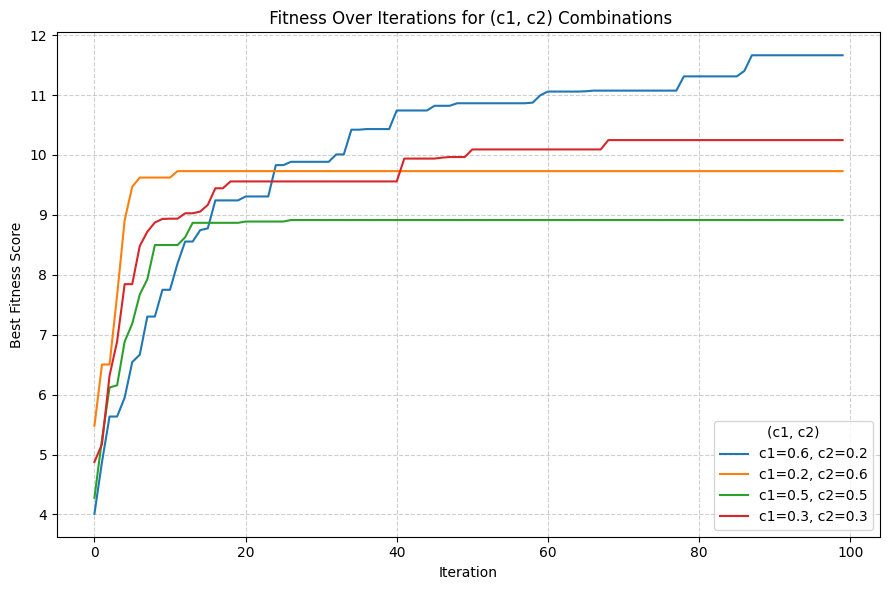

In [25]:
plt.figure(figsize=(9, 6))
for (c1, c2), scores in fitness_histories_c1c2.items():
    label = f'c1={c1}, c2={c2}'
    plt.plot(scores, label=label)

plt.title(" Fitness Over Iterations for (c1, c2) Combinations")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="(c1, c2)", loc='lower right')
plt.tight_layout()
plt.show()

## Iterations Number Experiments

In [26]:
# Run the particle swarm optimization algorithm
global_best_position, global_best_score, fitness_scores_pso, runtime_pso = particle_swarm_optimization(
    df=df_input,
    swarm_size=25,
    iterations=500,
    num_points=20,
    c1_start=0.6,
    c1_end=0.6,
    c2_start=0.3,
    c2_end=0.3,
    verbose=False
)



🐝 Initialized swarm with 25 particles, each selecting 20 points.

✅ Best 20 points saved to 'best_20_points_pso.csv'
⏱️ Runtime: 65.36 seconds


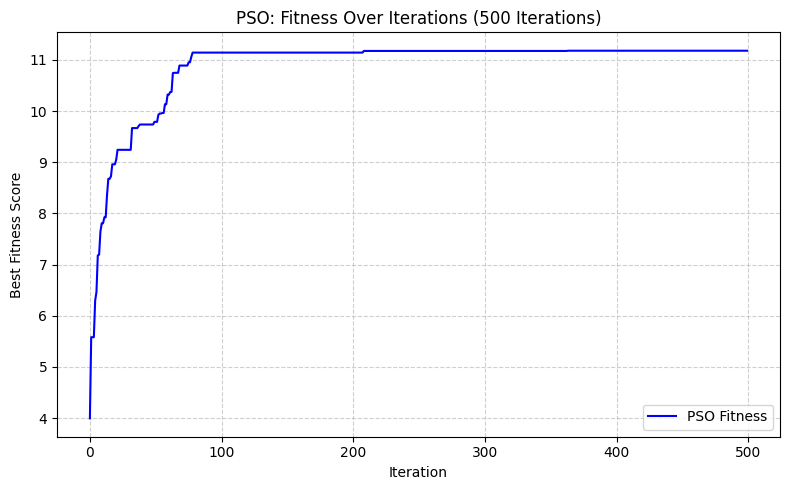

In [27]:
# Plot fitness over iterations

plt.figure(figsize=(8, 5))
plt.plot(fitness_scores_pso, label='PSO Fitness', color='blue')
plt.title("PSO: Fitness Over Iterations (500 Iterations)")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# Interactive PSO

In [29]:
# --- Layouts ---
slider_layout = Layout(width='600px', height='50px')
button_layout = Layout(width='300px', height='50px')

# --- Sliders ---
swarm_slider = widgets.IntSlider(
    value=75, min=25, max=100, step=5,
    description='🦟 Swarm Size:', style={'description_width': '150px'},
    layout=slider_layout
)

c1_slider = widgets.FloatSlider(
    value=0.5, min=0.0, max=1.0, step=0.1,
    description='🧠 Cognitive (c1):', style={'description_width': '150px'},
    layout=slider_layout
)

c2_slider = widgets.FloatSlider(
    value=0.5, min=0.0, max=1.0, step=0.1,
    description='🌍 Social (c2):', style={'description_width': '150px'},
    layout=slider_layout
)

iteration_slider = widgets.IntSlider(
    value=300, min=50, max=2000, step=50,
    description='🔁 Iterations:', style={'description_width': '150px'},
    layout=slider_layout
)

# --- Buttons ---
run_button_pso = widgets.Button(
    description="🚀 Run PSO",
    button_style='success',
    layout=button_layout
)
reset_button_pso = widgets.Button(
    description="🔄 Reset",
    button_style='warning',
    layout=button_layout
)

# --- Output ---
output_pso = widgets.Output()

# --- Update c2 max when c1 changes ---
def on_c1_change(change):
    new_c1 = change['new']
    c2_slider.max = max(0.0, 1.0 - new_c1)
    if c2_slider.value > c2_slider.max:
        c2_slider.value = c2_slider.max

c1_slider.observe(on_c1_change, names='value')

# --- Run PSO callback ---
def on_pso_click(b):
    with output_pso:
        clear_output(wait=True)
        
        c1_val = c1_slider.value
        c2_val = c2_slider.value

        # Run your decaying PSO function
        global_best_position, global_best_score, fitness_scores_pso, runtime_pso = particle_swarm_optimization(
            df=df_input.copy(),
            swarm_size=swarm_slider.value,
            iterations=iteration_slider.value,
            num_points=20,
            c1_start=c1_val,
            c1_end=c1_val,
            c2_start=c2_val,
            c2_end=c2_val,
            verbose=False
        )

        # --- Plot Fitness ---
        fig1, ax1 = plt.subplots(figsize=(8, 4), constrained_layout=True)
        ax1.plot(fitness_scores_pso, color='royalblue')
        ax1.set_title("📈 Fitness Score per Iteration")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Best Fitness")
        ax1.grid(True)
        plt.show()

        # --- Plot on Map ---
        """
        file_path = "./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
        world = gpd.read_file(file_path)
        turkey = world[world['ADMIN'] == 'Turkey']
        """
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) #if this does not work uncomment the code above
        turkey = world[world.name == "Turkey"]
        selected_points = pd.read_csv('best_20_points_pso.csv')
        gdf_points = gpd.GeoDataFrame(
            selected_points,
            geometry=gpd.points_from_xy(selected_points.lon, selected_points.lat),
            crs="EPSG:4326"
        )
        fig2, ax2 = plt.subplots(figsize=(8, 10), constrained_layout=True)
        turkey.plot(ax=ax2, color='whitesmoke', edgecolor='black')
        gdf_points.plot(ax=ax2, color='mediumvioletred', markersize=50, edgecolor='white')
        ax2.set_title("📍 Selected Solar Installation Points on Türkiye Map", fontsize=14)
        ax2.set_xlabel("Longitude")
        ax2.set_ylabel("Latitude")
        ax2.grid(True)
        plt.show()

# --- Reset PSO callback ---
def on_reset_click(b):
    swarm_slider.value = 75
    c1_slider.value = 0.5
    c2_slider.max = 0.5
    c2_slider.value = 0.5
    iteration_slider.value = 300
    output_pso.clear_output()

# --- Binding ---
def clear_and_bind(widget, callback):
    try:
        widget._click_handlers.callbacks.clear()
    except:
        pass
    widget.on_click(callback)

clear_and_bind(run_button_pso, on_pso_click)
clear_and_bind(reset_button_pso, on_reset_click)

# --- Layout ---
button_row_pso = HBox([run_button_pso, reset_button_pso], layout=Layout(justify_content='center', gap='20px'))

control_box_pso = VBox(
    [swarm_slider, c1_slider, c2_slider, iteration_slider, button_row_pso],
    layout=Layout(
        border='2px solid lightgray',
        border_radius='10px',
        box_shadow='2px 2px 5px rgba(0,0,0,0.1)',
        padding='20px',
        width='700px',
        align_items='center',
        background_color='white'
    )
)

output_pso.layout = Layout(width='900px', align_items='center')

# --- Display ---
if not hasattr(run_button_pso, "_already_displayed"):
    display(VBox([control_box_pso, widgets.HBox([output_pso], layout=Layout(justify_content='center', width='100%'))],
                 layout=Layout(align_items='center', width='100%')))
    run_button_pso._already_displayed = True


# Comparison Between GA, PSO, SA and Greedy 

In [14]:
# Here we are comparing according to one run, under the best hyperparameters tuned for each algorithm

# === Load result files ===
ga_points = pd.read_csv("best_20_points_ga_optimal.csv")
pso_points = pd.read_csv("best_20_points_pso_optimal.csv")

# === Compute pairwise geodesic distances ===
def compute_pairwise_distances(coords):
    distances = []
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            d = geodesic(coords[i], coords[j]).km
            distances.append(d)
    return np.array(distances)

# === Define the evaluation function ===
def evaluate_set(df, label, runtime_sec, best_fitness):
    coords = df[['lat', 'lon']].values
    distances = compute_pairwise_distances(coords)
    return {
        "Method": label,
        "Best Fitness": round(best_fitness, 6),
        "Mean Score": round(df["avg_score"].mean(), 4),
        "Mean Distance (km)": round(distances.mean(), 2),
        "Min Distance (km)": round(distances.min(), 2),
        "Runtime (sec)": round(runtime_sec, 2)
    }

# === Build comparison table ===
results = [
    evaluate_set(ga_points, "Genetic Algorithm", runtime_ga_optimal, best_fitness_ga_optimal),
    evaluate_set(pso_points, "Particle Swarm Optimization", runtime_pso_optimal,  global_best_score_optimal)
]

df_comparison = pd.DataFrame(results)

# After adding the 'Optimal Location' column to each dataset:
highest_ga = ga_points["avg_score"].max()
highest_pso = pso_points["avg_score"].max()

# Add Optimal Location column to df_comparison
df_comparison["Optimal Location (avg_score)"] = [
    
    highest_ga,
    highest_pso
]

# Display the updated df_comparison
from IPython.display import display
display(df_comparison)


,Method,Best Fitness,Mean Score,Mean Distance (km),Min Distance (km),Runtime (sec),Optimal Location (avg_score)
0,Genetic Algorithm,12.618008,0.6866,649.94,47.47,142.01,0.81846
1,Particle Swarm Optimization,11.632336,0.6918,599.56,46.67,26.61,0.81846


# Results Visulization on the map

C:\Users\aya20\AppData\Local\Temp\ipykernel_20508\1360651671.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\aya20\AppData\Local\Temp\ipykernel_20508\1360651671.py:47: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  plt.tight_layout()
C:\Users\aya20\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


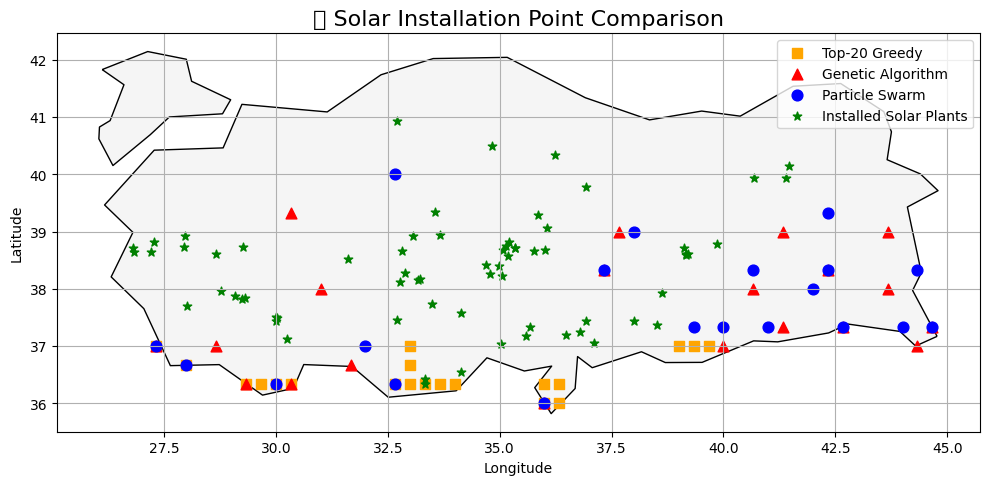

In [15]:
# === Load result files ===
ga_df = pd.read_csv("best_20_points_ga_optimal.csv")
pso_df = pd.read_csv("best_20_points_pso_optimal.csv")
top20_df = pd.read_csv("best_20_points_greedy.csv")
solar_df = pd.read_csv("turkey_solar_filtered.csv")

# === Convert to GeoDataFrames ===
def make_gdf(df, lat_col="lat", lon_col="lon"):
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326"
    )

gdf_ga = make_gdf(ga_df)
gdf_pso = make_gdf(pso_df)
gdf_top20 = make_gdf(top20_df)
gdf_solar = make_gdf(solar_df, lat_col="latitude", lon_col="longitude")  # Use correct columns for solar_df

# === Load Türkiye shape ===


world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
turkey = world[world.name == "Turkey"] #If this does not work uncomment the code below

"""
file_path = "./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(file_path)
turkey = world[world['ADMIN'] == 'Turkey']
"""

# === Plot all four sets ===
fig, ax = plt.subplots(figsize=(10, 12))
turkey.plot(ax=ax, color='whitesmoke', edgecolor='black')

gdf_top20.plot(ax=ax, color='orange', marker='s', markersize=60, label="Top-20 Greedy")
gdf_ga.plot(ax=ax, color='red', marker='^', markersize=60, label="Genetic Algorithm")
gdf_pso.plot(ax=ax, color='blue', marker='o', markersize=60, label="Particle Swarm")
gdf_solar.plot(ax=ax, color='green', marker='*', markersize=40, label="Installed Solar Plants")

# === Labels and layout ===
plt.title("📍 Solar Installation Point Comparison", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interactiv Map

In [16]:
# Note: the size of the point found by the algorithms indicates points' solar suitability score.
# The size of existing solar panels (Green) points indicates the amount of power they generate.

# === Load your result files ===
ga_df = pd.read_csv("best_20_points_ga_optimal.csv")
pso_df = pd.read_csv("best_20_points_pso_optimal.csv")
top20_df = pd.read_csv("best_20_points_greedy.csv")

# === Load real solar power plant data ===
solar_df = pd.read_csv("turkey_solar_filtered.csv")  

# === Center the map over Türkiye ===
center_lat = pd.concat([ga_df, pso_df, top20_df])["lat"].mean()
center_lon = pd.concat([ga_df, pso_df, top20_df])["lon"].mean()

# === Create satellite base map ===
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles=None,
    scrollWheelZoom=True,
    max_zoom=18,
    min_zoom=2,
    prefer_canvas=False, 
    zoom_control=True
)

# ESRI Satellite
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    name="Esri Satellite",
    overlay=False,
    control=True
).add_to(m)

# === Add optimization result layers ===
def add_markers(df, name, color):
    group = folium.FeatureGroup(name=name)

    max_score_idx = df['avg_score'].idxmax()  # index of the point with highest score
    max_score = df.loc[max_score_idx, 'avg_score']

    for i, row in df.iterrows():
        score = row['avg_score']
        radius = min(max((score - 0.5) * 30, 4), 12)  # scale between 4–12 (tweak as needed)

        if i == max_score_idx:
            folium.Marker(
                location=[row['lat'], row['lon']],
                icon=folium.Icon(icon='star', color=color, prefix='fa'),
                popup=f"{name}<br><b>⭐ BEST</b><br>Score: {score:.4f}",
                tooltip=f"{name} – ⭐ Best<br>Score: {score:.4f}"
            ).add_to(group)
        else:
            folium.CircleMarker(
                location=[row['lat'], row['lon']],
                radius=radius,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.85,
                popup=f"{name}<br>Score: {score:.4f}",
                tooltip=f"{name}<br>Score: {score:.4f}"
            ).add_to(group)
    group.add_to(m)


add_markers(top20_df, "Top-20 Greedy", "orange")
add_markers(ga_df, "Genetic Algorithm", "red")
add_markers(pso_df, "Particle Swarm Optimization", "blue")


# === Add real installed solar plants layer with variable size ===
solar_group = folium.FeatureGroup(name="☀ Installed Solar Plants")

# Get min/max capacity for normalization 
min_cap = solar_df["capacity_mw"].min()
max_cap = solar_df["capacity_mw"].max()

for _, row in solar_df.iterrows():
    capacity = row['capacity_mw']

    # Normalize and scale radius from 4 to 16 (adjust range as needed)
    norm_capacity = (capacity - min_cap) / ((max_cap - min_cap + 1e-6)*2)
    radius = 4 + norm_capacity * 12  # radius between 4 and 16

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.7,
        popup=f"{row['name']}<br>{capacity:.1f} MW",
        tooltip=f"{row['name']} – {capacity:.1f} MW"
    ).add_to(solar_group)


solar_group.add_to(m)


# === Add layer control toggle ===
folium.LayerControl().add_to(m)

# === Display the map ===
m
